In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from plotly.offline import init_notebook_mode, iplot
from sklearn.preprocessing import OrdinalEncoder
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e17/sample_submission.csv
/kaggle/input/playground-series-s3e17/train.csv
/kaggle/input/playground-series-s3e17/test.csv


## Import the data

In [2]:
## import the train dataset
df_train = pd.read_csv('/kaggle/input/playground-series-s3e17/train.csv')
df_train.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [3]:
### load the test data
df_test = pd.read_csv('/kaggle/input/playground-series-s3e17/test.csv')
df_test.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,136429,L50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0
1,136430,L53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0
2,136431,L50498,L,301.3,310.4,1525,37.7,96,0,0,0,0,0
3,136432,M21232,M,300.1,309.6,1479,47.6,5,0,0,0,0,0
4,136433,M19751,M,303.4,312.3,1515,41.3,114,0,0,0,0,0


In [4]:
def check_data(data, data_type):
    data = data.drop('id', axis=1)
    print(f"basic informataion on {data_type} \n")

    basics = {"data info": data.info(),"data types are":data.dtypes, 'length of the dataset':len(data), 
              'null values are':data.isnull().sum(), 'distribution of the dataset':data.describe()}

    [print('*'*50, '\n', i, '\n',j) for i,j in basics.items()]

In [5]:
check_data(df_train, 'TRAIN DATA')

basic informataion on TRAIN DATA 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136429 entries, 0 to 136428
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Product ID               136429 non-null  object 
 1   Type                     136429 non-null  object 
 2   Air temperature [K]      136429 non-null  float64
 3   Process temperature [K]  136429 non-null  float64
 4   Rotational speed [rpm]   136429 non-null  int64  
 5   Torque [Nm]              136429 non-null  float64
 6   Tool wear [min]          136429 non-null  int64  
 7   Machine failure          136429 non-null  int64  
 8   TWF                      136429 non-null  int64  
 9   HDF                      136429 non-null  int64  
 10  PWF                      136429 non-null  int64  
 11  OSF                      136429 non-null  int64  
 12  RNF                      136429 non-null  int64  
dtypes: float64(3), int64(8),

In [6]:
check_data(df_test, 'TEST DATA')

basic informataion on TEST DATA 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90954 entries, 0 to 90953
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product ID               90954 non-null  object 
 1   Type                     90954 non-null  object 
 2   Air temperature [K]      90954 non-null  float64
 3   Process temperature [K]  90954 non-null  float64
 4   Rotational speed [rpm]   90954 non-null  int64  
 5   Torque [Nm]              90954 non-null  float64
 6   Tool wear [min]          90954 non-null  int64  
 7   TWF                      90954 non-null  int64  
 8   HDF                      90954 non-null  int64  
 9   PWF                      90954 non-null  int64  
 10  OSF                      90954 non-null  int64  
 11  RNF                      90954 non-null  int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 8.3+ MB
***************************************

In [7]:
### check the unique values of last 5 columns. because it seems that those columns have categorical data

for data in df_train.columns[-5:]:
    print(f"unique values of {data} are :{df_train[data].unique()}")

unique values of TWF are :[0 1]
unique values of HDF are :[0 1]
unique values of PWF are :[0 1]
unique values of OSF are :[0 1]
unique values of RNF are :[0 1]


## Exploratory data analysis

In [8]:
### categorical data analysis
cate_cols = ['Type', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
def plot_categorical(data):
    plt.figure(figsize=(12,10))
    for id, column in enumerate(cate_cols):
        plt.subplot(3,2, id+1)
        sns.countplot(x=data[column], data = data)
        plt.tight_layout()

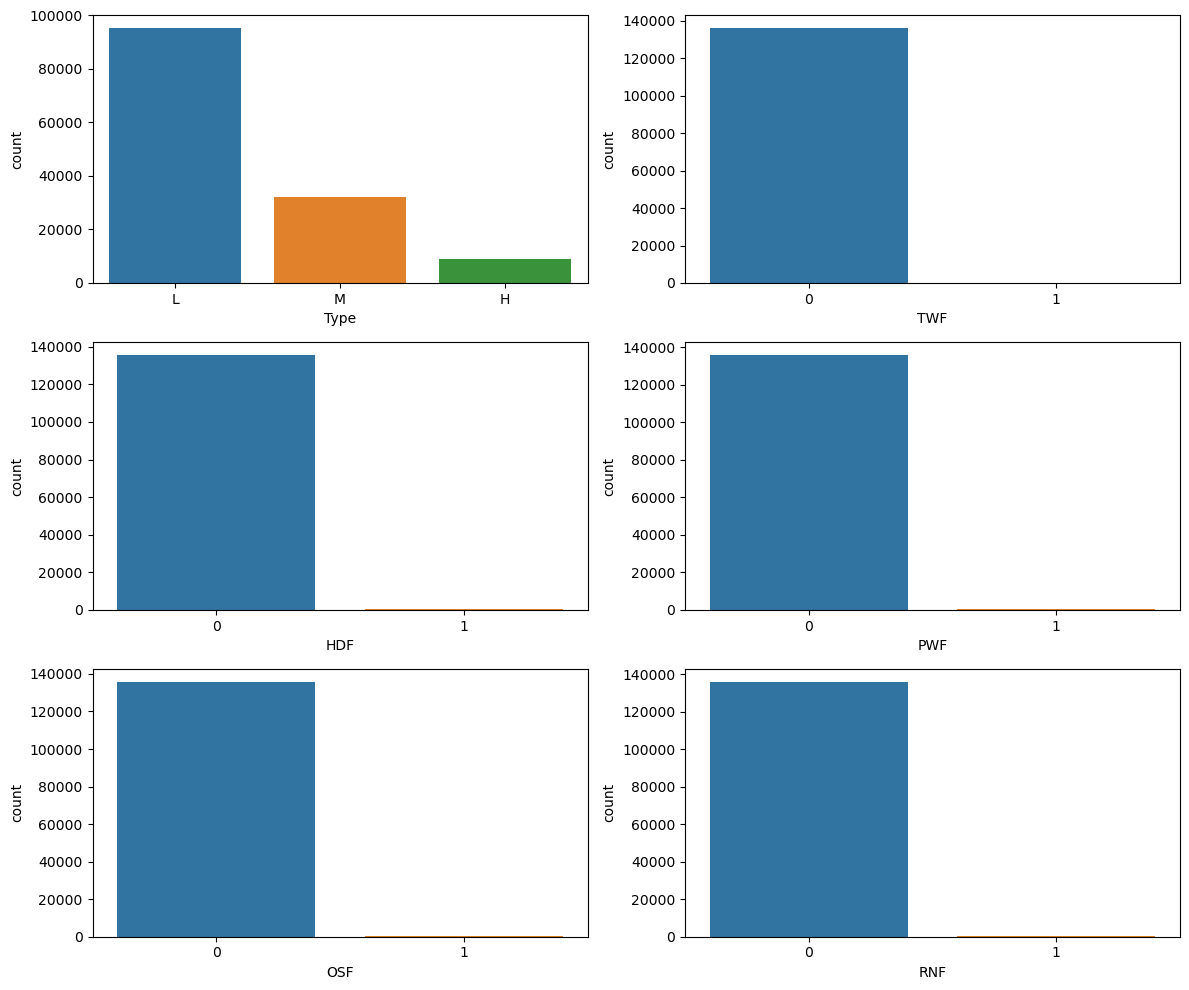

In [9]:
plot_categorical(df_train)

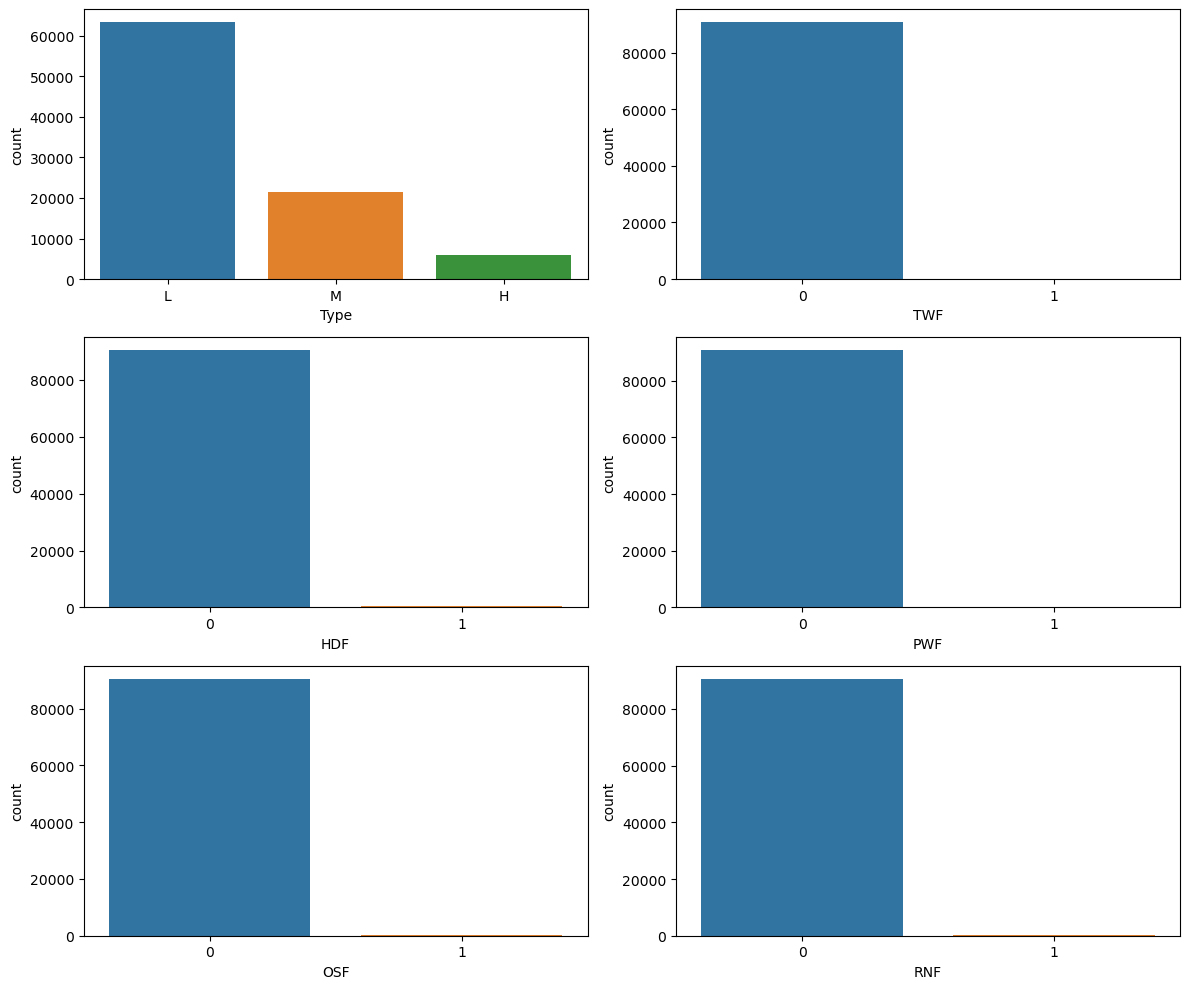

In [10]:
plot_categorical(df_test)

Categorical variables in both train and test dataset are biased to 0. almost all the data are 0. 

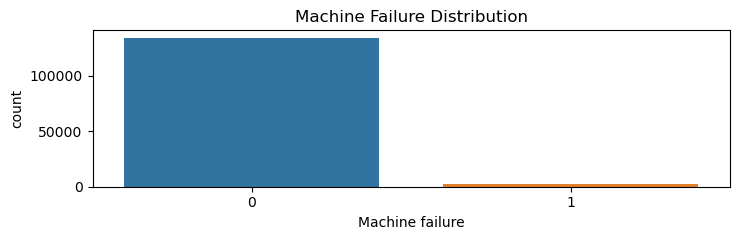

In [11]:
### Target variable distribution

plt.figure(figsize=(7.5,2.5))
sns.countplot(x=df_train['Machine failure'], data=df_train)
plt.title("Machine Failure Distribution")

plt.tight_layout()

we can see that dataset is heavily inbalanced. we can assume that negative class ratio should be more that 95%. so when applying the ml algorithms we need to consider techniques to reduce the class imbalance.

In [12]:
df_train.columns

Index(['id', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')

In [13]:
## plot continuous data
def plot_data(data, data_type, plot_type):
    plt.figure(figsize=(15,10))
    if data_type == 'train':
        columns = data.columns[3:-6]
    else:
        columns = data.columns[3:-5]
        
    for id,column in enumerate(columns):  # we leave id and age features. because id is not important and the age is a categorical feature
        plt.subplot(3,2,id+1)
        if plot_type == 'hist':
            sns.histplot(x=column,data=df_train, kde=True)
            plt.title(f"{column} Distribution")
        elif plot_type == 'kde':
            sns.kdeplot(x=column,data=df_train, fill=True)
            plt.title(f"{column} Distribution")
        elif plot_type == 'box':
            sns.boxplot(x=column,data=df_train)
            plt.title(f"{column} Distribution")

        plt.tight_layout()

### Distribution of Training data

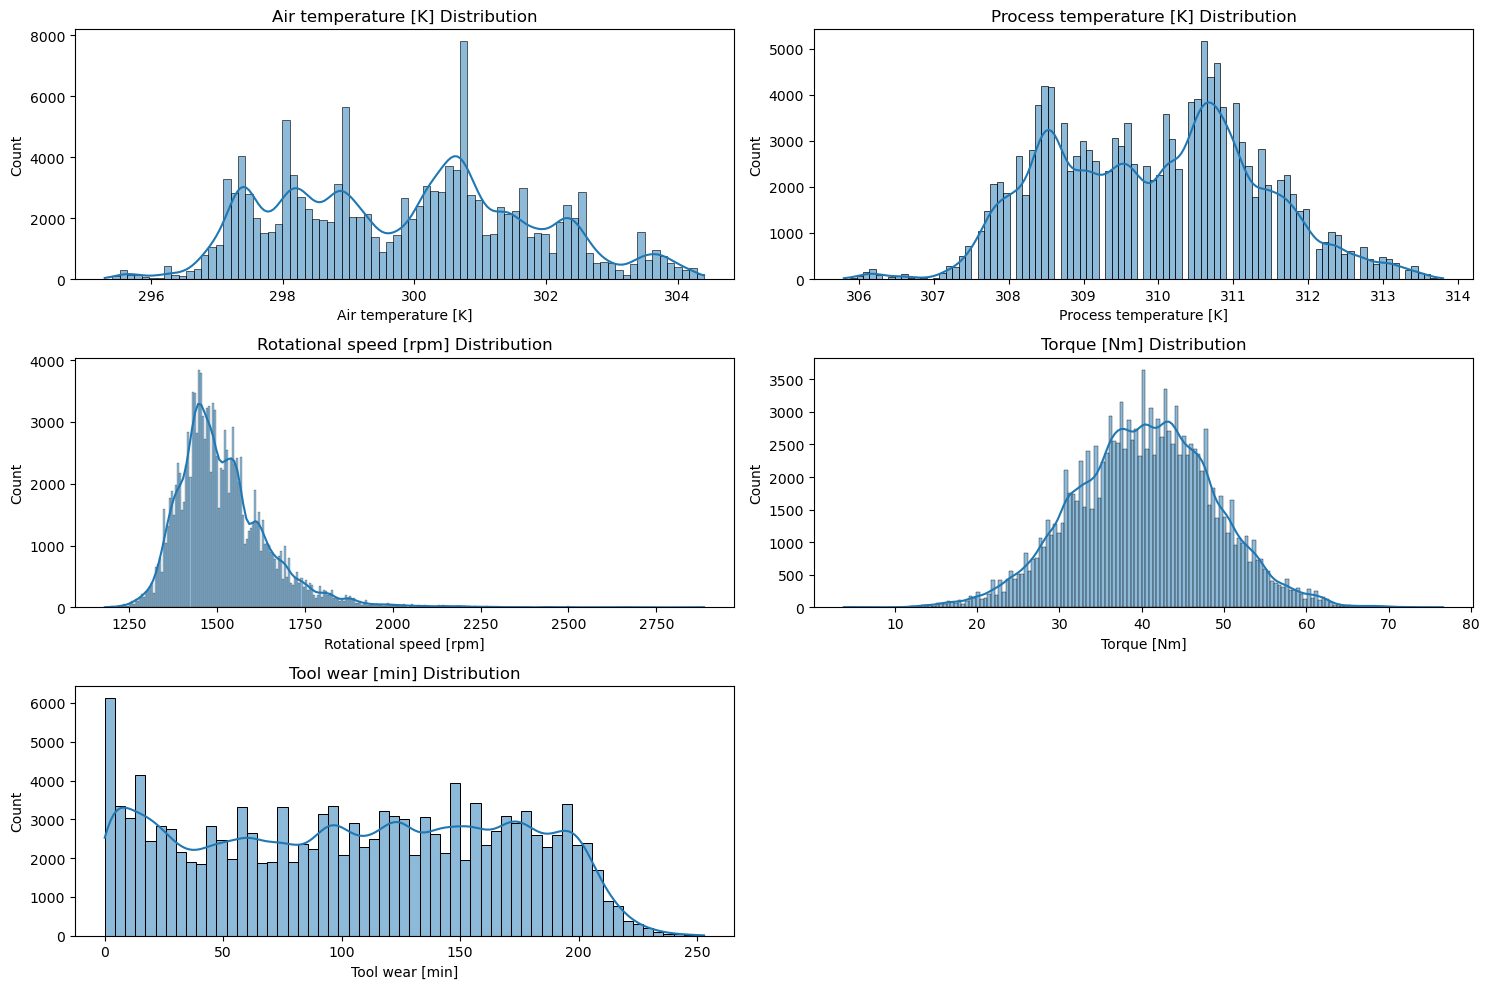

In [14]:
plot_data(df_train, 'train', 'hist')

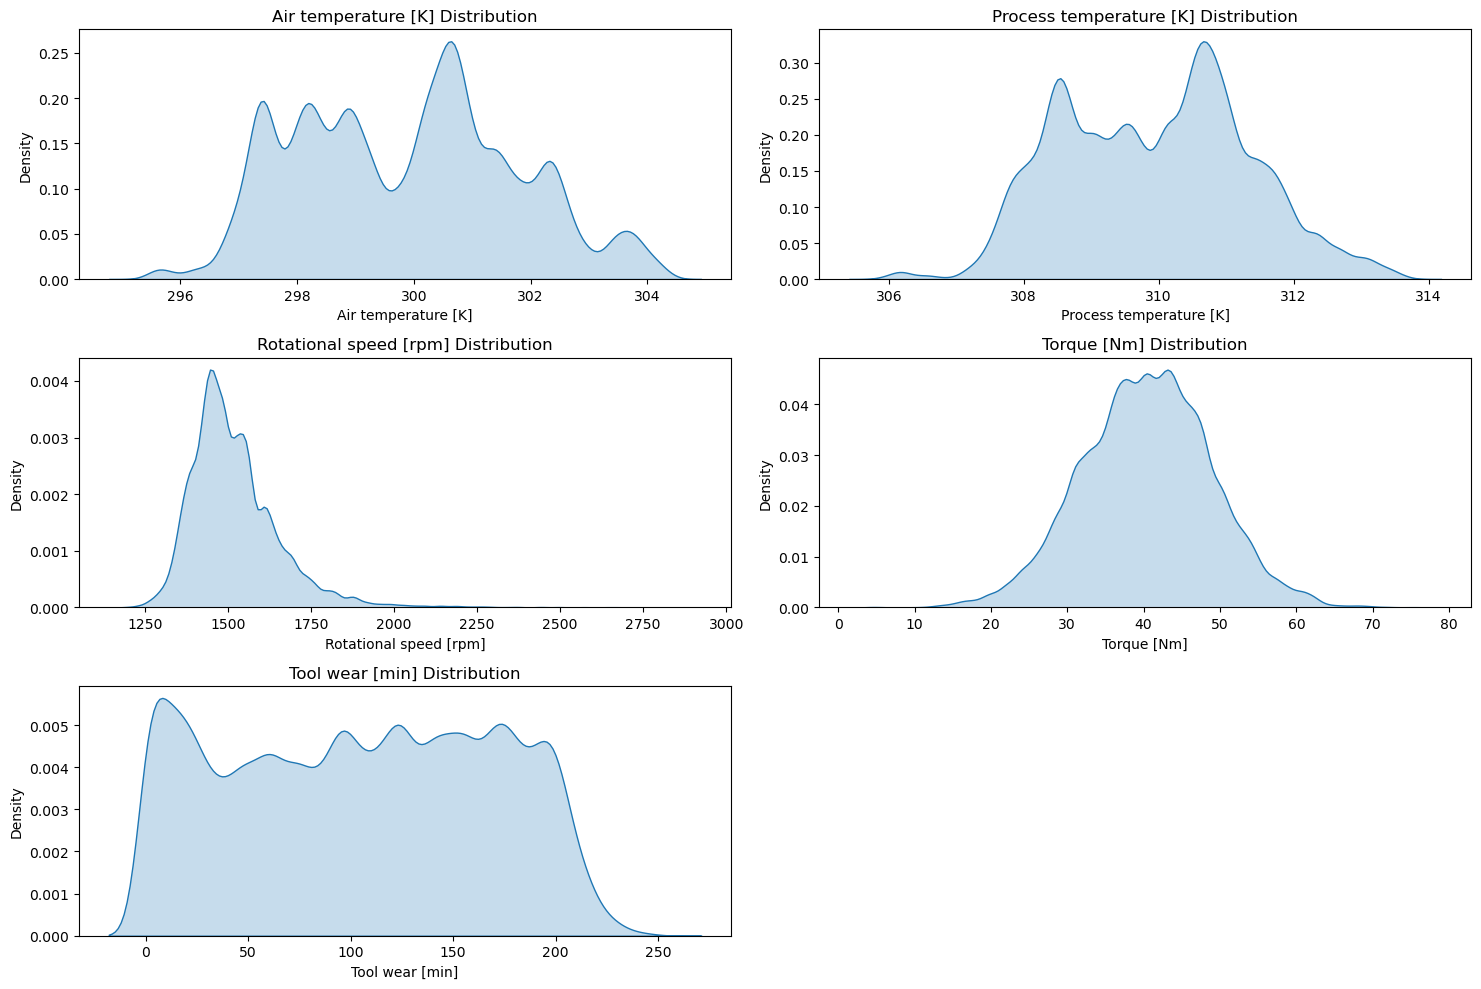

In [15]:
plot_data(df_train, 'train', 'kde')

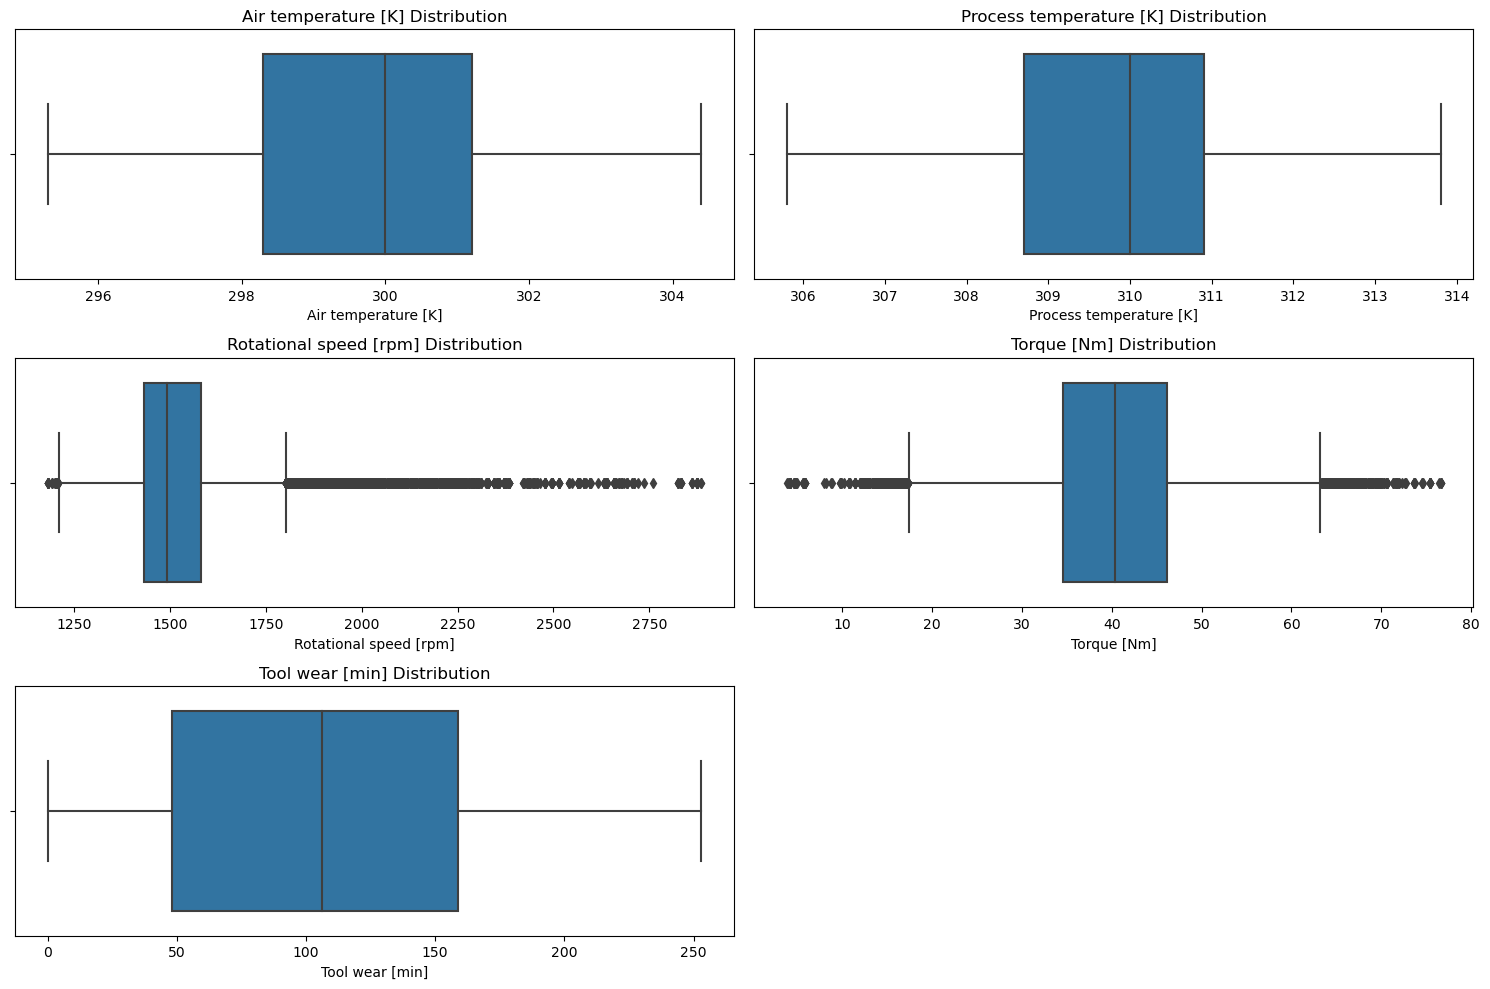

In [16]:
plot_data(df_train, 'train', 'box')

### Distribution of test data

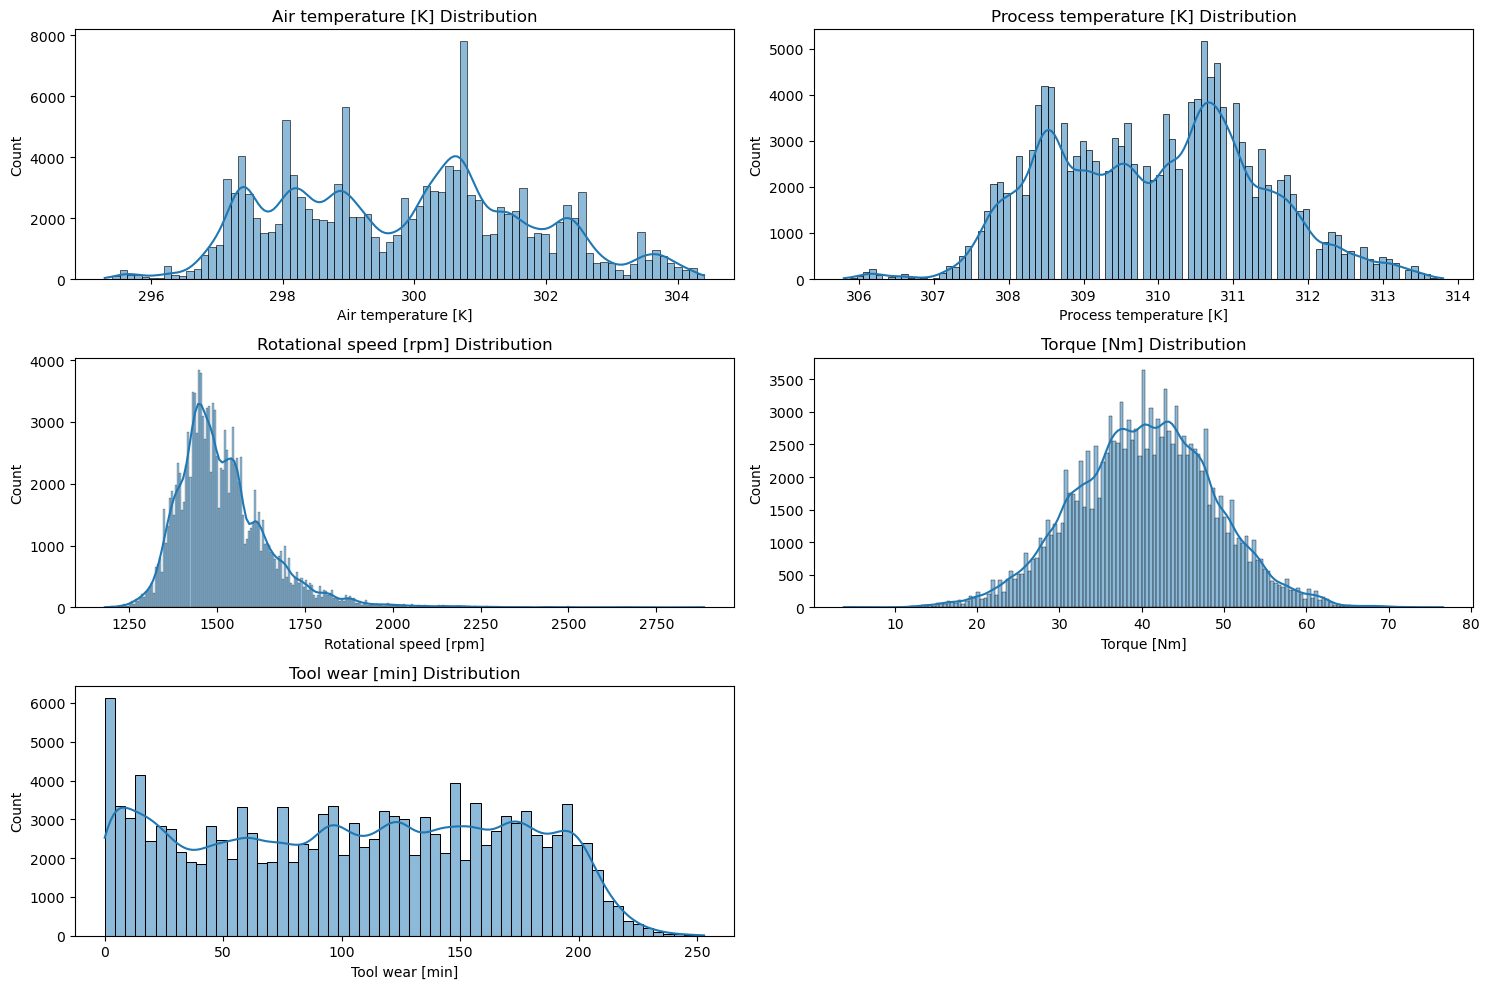

In [17]:
plot_data(df_test, 'test', 'hist')

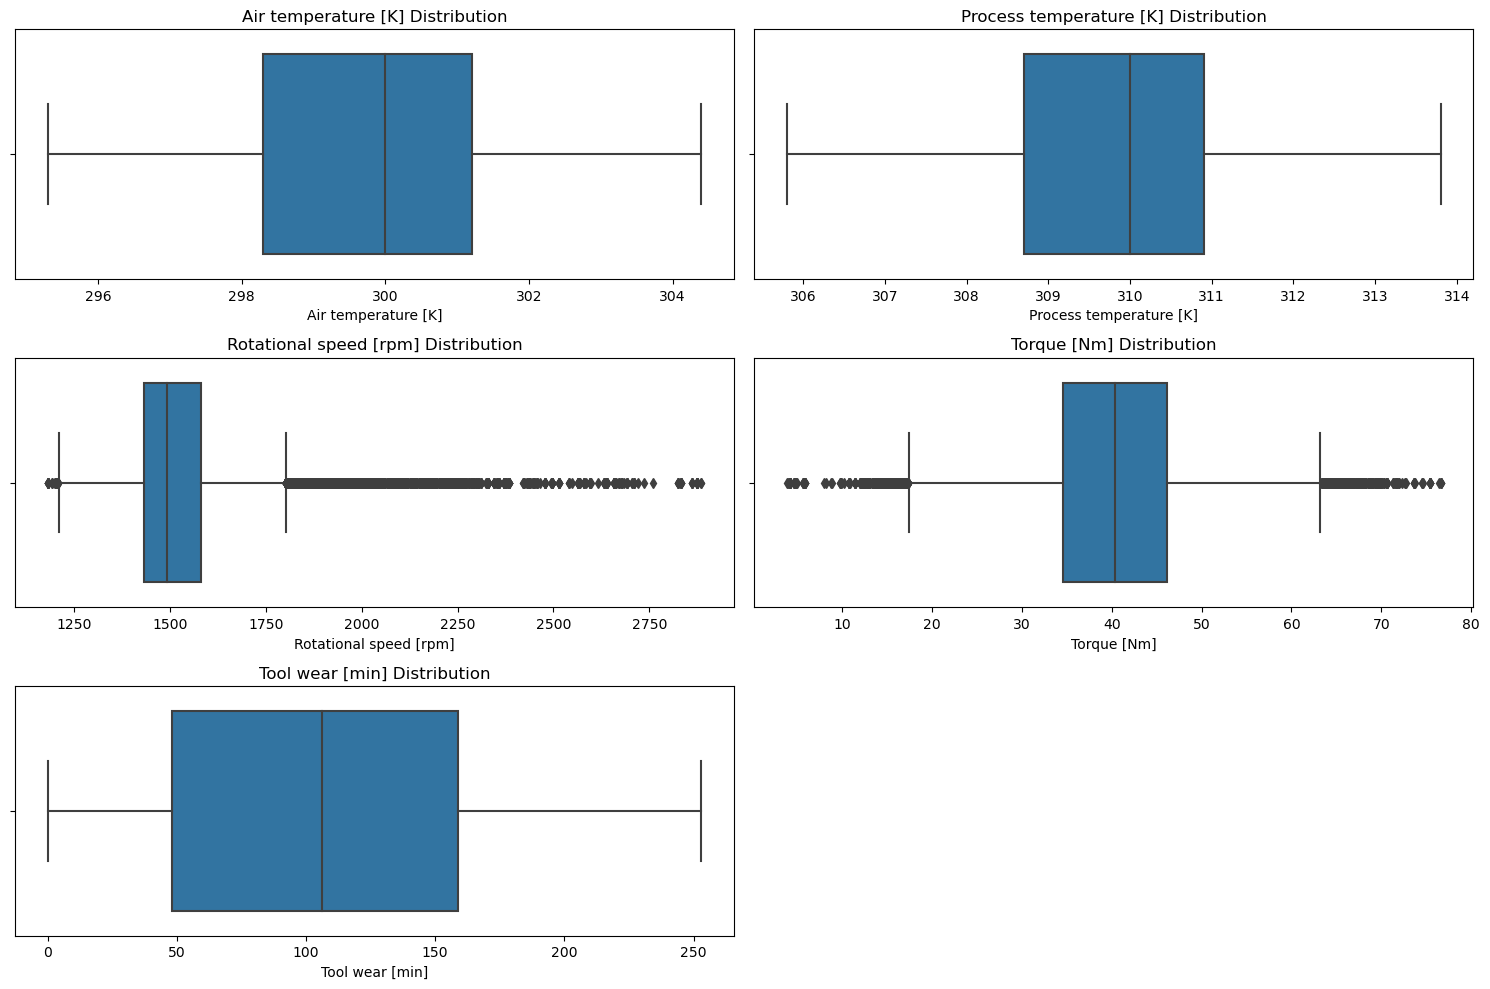

In [18]:
plot_data(df_test, 'test', 'box')

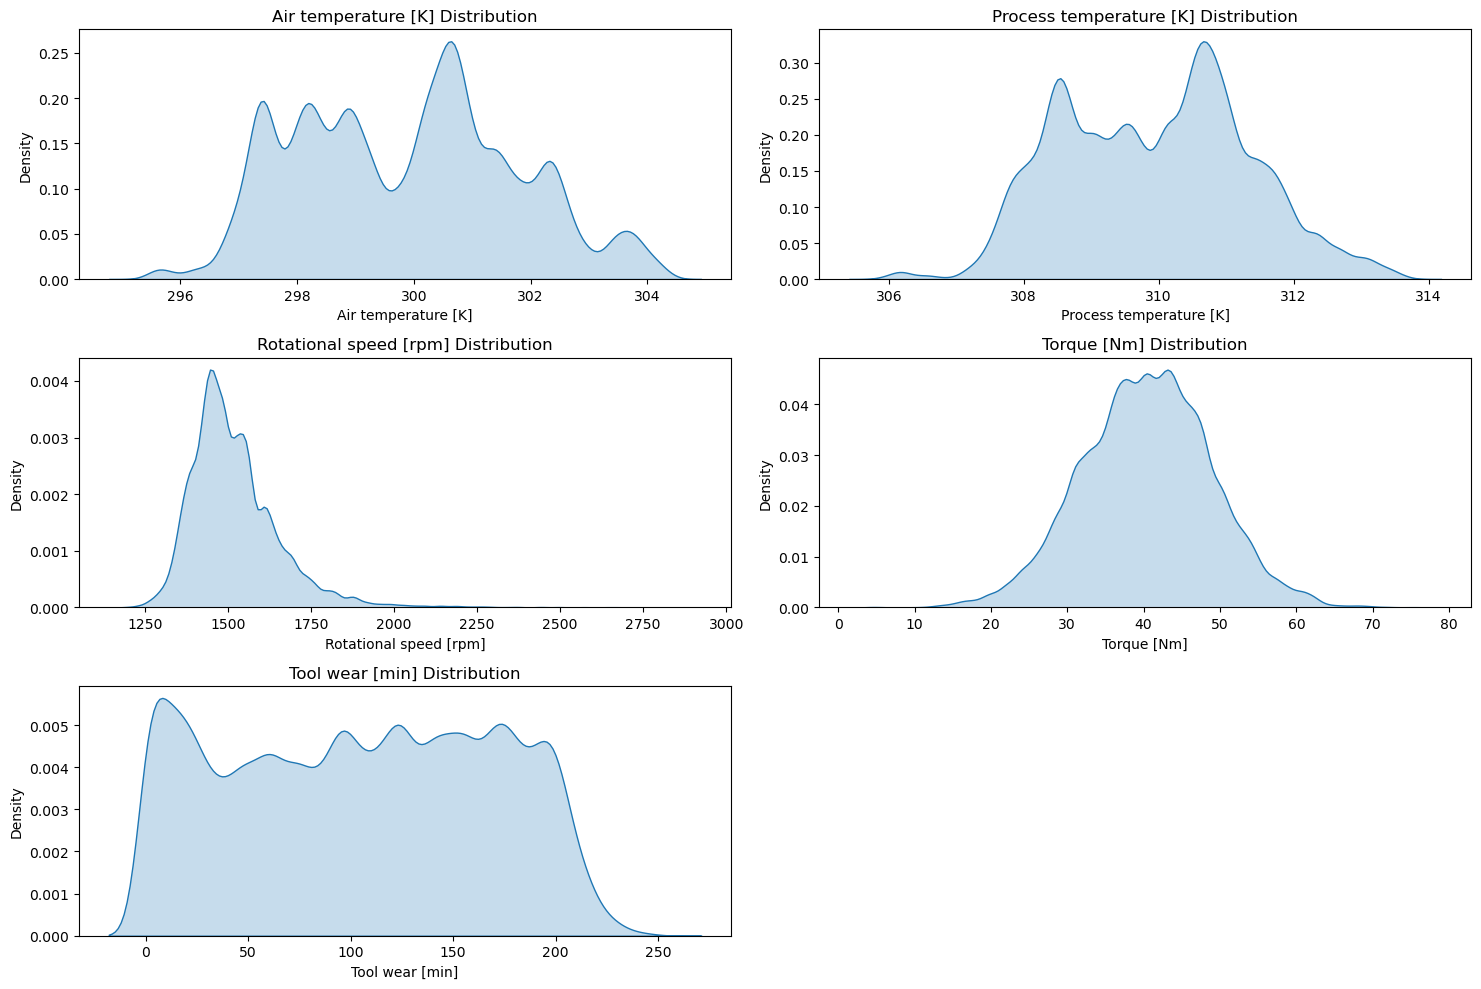

In [19]:
plot_data(df_test, 'test', 'kde')

## Feature Engineering

#############################  TO Be Continued ##############################